In [1]:
from __future__ import division, print_function, unicode_literals

import numpy as np 
import os 
import sys 

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 


In [2]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [3]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [4]:
import numpy.random as rnd

rnd.seed(4)
m = 200 
w1, w2, = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m)/2
data[:, 1] = np.sin(angles) + 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [6]:
import tensorflow as tf
reset_graph()

n_inputs = 3 
n_hidden = 2 
n_outputs = n_inputs

learning_rate = 0.01
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [7]:
n_iterations = 1000
codings = hidden 

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X:X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

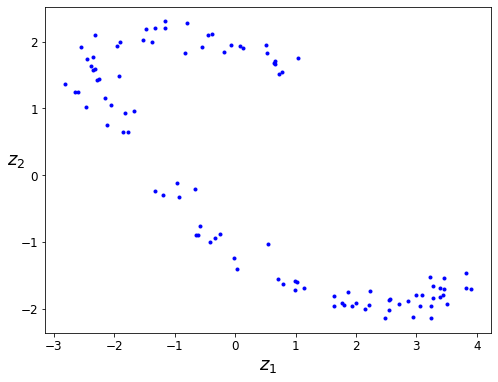

In [8]:
fig = plt.figure(figsize=(8,6))
plt.plot(codings_val[:, 0], codings_val[:, 1],"b.")
plt.xlabel("$z_1$",fontsize=18)
plt.ylabel("$z_2$",fontsize=18, rotation=0)
plt.show()

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data\train-labels-idx1-ubyte.gz
Extracting /tmp/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [10]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu,
                        kernel_initializer = he_init, kernel_regularizer = l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [11]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                         
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        print("\r{}".format(epoch), "Train MSE:", loss_train)           
        saver.save(sess, "./my_model_all_layers.ckpt")                  

0 Train MSE: 0.021493401
1 Train MSE: 0.011426802
2 Train MSE: 0.010240865
3 Train MSE: 0.009905783
4 Train MSE: 0.010374968


In [12]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 4):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


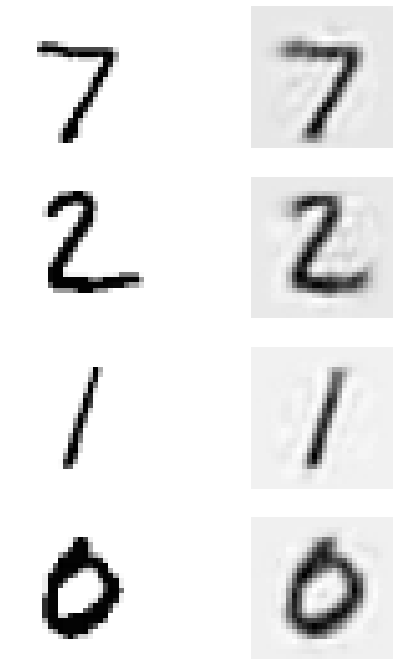

In [13]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")

In [14]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01 
l2_reg = 0.0005

In [15]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")
weights4 = tf.transpose(weights1, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [16]:
saver = tf.train.Saver()

In [17]:
n_epochs = 5
batch_size = 150 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch),"Train MSE:", loss_train)
        saver.save(sess,"./my_model_tying_weights.ckpt")

0 Train MSE: 0.015066945
1 Train MSE: 0.016488744
2 Train MSE: 0.017375935
3 Train MSE: 0.01687833
4 Train MSE: 0.015587721


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


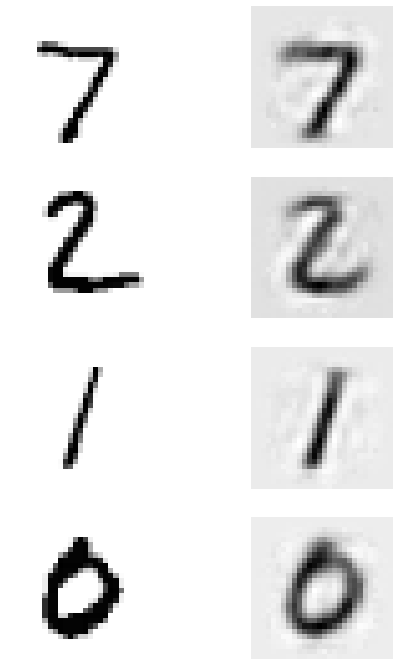

In [18]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

In [19]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [20]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.01851794
1 Train MSE: 0.01868272
2 Train MSE: 0.018467719
3 Train MSE: 0.01923175
0 Train MSE: 0.0042360914
1 Train MSE: 0.004832628
2 Train MSE: 0.004668704
3 Train MSE: 0.0044038715


In [21]:
reset_graph()
n_inputs = 28 * 28 

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

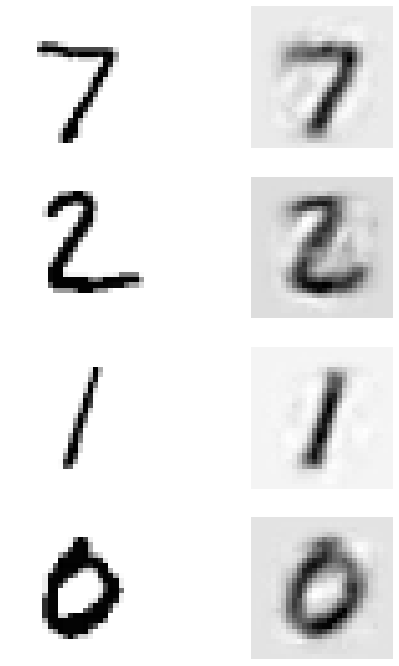

In [22]:
show_reconstructed_digits(X, outputs)

In [23]:
reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="buases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [24]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)
    
with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list =train_vars)

In [25]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [26]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.007406866
1 Train MSE: 0.0078288205
2 Train MSE: 0.007728097
3 Train MSE: 0.0074090064
Training phase #2
0 Train MSE: 0.34834248
1 Train MSE: 0.005979652
2 Train MSE: 0.0029750783
3 Train MSE: 0.0024357992
Test MSE: 0.009800645


In [27]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
09% Train MSE: 0.0075382586
1 Train MSE: 0.007754701
2 Train MSE: 0.007343679
3 Train MSE: 0.007837775
Training phase #2
0 Train MSE: 0.18607096
1 Train MSE: 0.0050415695
2 Train MSE: 0.0024354032
3 Train MSE: 0.0020589055
Test MSE: 0.009797439


INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


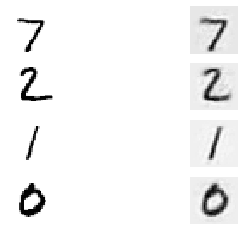

In [28]:
n_test_digits = 4
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt")
    outputs_val = outputs.eval(feed_dict={X: X_test})
    
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape),cmap="Greys",interpolation="nearest")
    plt.axis("off")
    
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


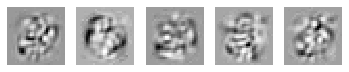

<Figure size 2304x2304 with 0 Axes>

In [29]:
with tf.Session() as sess:
    saver.restore(sess,"./my_model_one_at_a_time.ckpt")
    weights1_val = weights1.eval()
    
for i in range(5):
    plt.subplot(1,5,i+1)
    plot_image(weights1_val.T[i])
    
plt.figure(figsize=(32,32))
plt.show()

In [30]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [31]:
n_epochs = 4 
batch_size = 150 
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indicies = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch),"Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy", accuracy_val)

0 Train accuracy: 0.9737091 Test accuracy 0.9672
1 Train accuracy: 0.9885455 Test accuracy 0.9762
2 Train accuracy: 0.97443634 Test accuracy 0.9665
3 Train accuracy: 0.98663634 Test accuracy 0.9743


In [32]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.97333336	Test accuracy: 0.926
1 Train accuracy: 0.98	Test accuracy: 0.9384
2 Train accuracy: 0.98	Test accuracy: 0.943
3 Train accuracy: 0.96666664	Test accuracy: 0.9371


In [33]:
reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1 
n_outputs = n_inputs

learning_rate = 0.01

In [34]:
noise_level = 1.0
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [35]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
n_epochs = 10 
batch_size = 150 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch),"Train MSE: ",loss_train)
        saver.save(sess,"./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE:  0.04390057
1 Train MSE:  0.04327198
2 Train MSE:  0.042042878
3 Train MSE:  0.040703475
4 Train MSE:  0.040245567
5 Train MSE:  0.038696505
6 Train MSE:  0.039343018
7 Train MSE:  0.04257301
8 Train MSE:  0.04024972
9 Train MSE:  0.04160908


In [37]:
#Using dropout
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 
n_hidden3 =  n_hidden1

learning_rate = 0.01

In [38]:
dropout_rate = 0.3
training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [39]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [40]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.029460266
1 Train MSE: 0.028333139
2 Train MSE: 0.025265342
3 Train MSE: 0.025670337
4 Train MSE: 0.02505453
5 Train MSE: 0.025872625
6 Train MSE: 0.024758691
7 Train MSE: 0.02550465
8 Train MSE: 0.02518992
9 Train MSE: 0.024919135


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


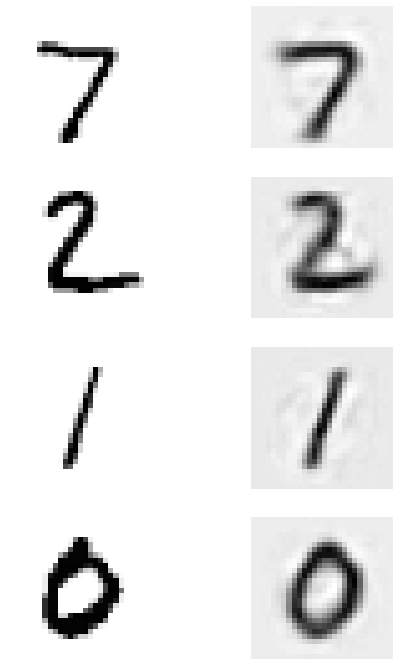

In [41]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

[0, 1, 0, 0.95]

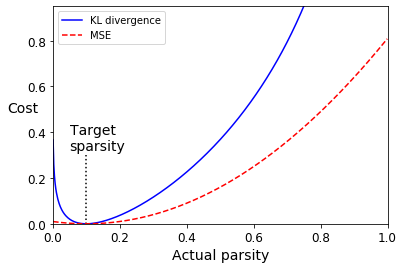

In [42]:
p = 0.1 
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p/q) + (1-p) * np.log((1-p)/(1-q))
mse = (p-q)**2
plt.plot([p, p],[0, 0.3], "k:")
plt.text(0.05,0.32, "Target\nsparsity",fontsize=14)
plt.plot(q, kl_div,"b-",label="KL divergence")
plt.plot(q, mse, "r--",label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual parsity")
plt.ylabel("Cost",rotation=0)
plt.axis([0, 1, 0, 0.95])

In [43]:
reset_graph()

n_inputs = 28 * 28 
n_hidden1 = 1000
n_outputs = n_inputs

In [44]:
#Kullback-Leibler divergence
def kl_divergence(p, q):
    return p * tf.log(p/q) + (1-p)*tf.log((1-p)/(1-q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1, n_outputs)

hidden1_mean = tf.reduce_mean(hidden1,axis=0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)  

In [45]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [46]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss],feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val,"\tSparsity loss:",sparsity_loss_val,"\tTotal loss:",loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.13819475 	Sparsity loss: 0.41844413 	Total loss: 0.22188358
1 Train MSE: 0.059185907 	Sparsity loss: 0.010747653 	Total loss: 0.061335437
2 Train MSE: 0.053931113 	Sparsity loss: 0.019957468 	Total loss: 0.057922605
3 Train MSE: 0.04771372 	Sparsity loss: 0.039470937 	Total loss: 0.055607907
4 Train MSE: 0.044841796 	Sparsity loss: 0.011593082 	Total loss: 0.047160413
5 Train MSE: 0.04044193 	Sparsity loss: 0.09246916 	Total loss: 0.05893576
6 Train MSE: 0.03886659 	Sparsity loss: 0.045811534 	Total loss: 0.048028897
7 Train MSE: 0.037868652 	Sparsity loss: 0.0749799 	Total loss: 0.052864634
8 Train MSE: 0.033122517 	Sparsity loss: 0.020322183 	Total loss: 0.037186954
98% Train MSE: 0.031449173 	Sparsity loss: 0.095670395 	Total loss: 0.05058325
10% Train MSE: 0.027398113 	Sparsity loss: 0.065706715 	Total loss: 0.04053946
11 Train MSE: 0.024734963 	Sparsity loss: 0.08889331 	Total loss: 0.042513624
12 Train MSE: 0.023367295 	Sparsity loss: 0.057660993 	Total loss: 0.034

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


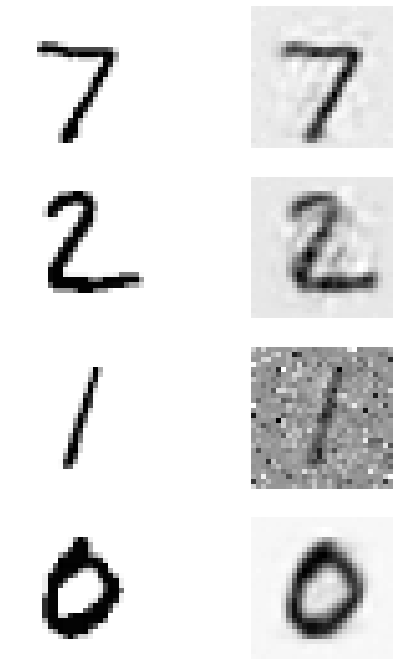

In [47]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

In [48]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)

In [49]:
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

In [50]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [51]:
eps = 1e-10 
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [52]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [53]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

09% Train total loss: 28985.145 	Reconstruction loss: 23342.797 	Latent loss: 5642.347
1 Train total loss: 34219.312 	Reconstruction loss: 23981.613 	Latent loss: 10237.697
2 Train total loss: 31462.223 	Reconstruction loss: 25501.3 	Latent loss: 5960.9214
3 Train total loss: 24719.574 	Reconstruction loss: 20762.422 	Latent loss: 3957.1519
4 Train total loss: 22821.863 	Reconstruction loss: 19872.977 	Latent loss: 2948.8872
5 Train total loss: 21471.1 	Reconstruction loss: 18288.871 	Latent loss: 3182.229
6 Train total loss: 19428.887 	Reconstruction loss: 16467.492 	Latent loss: 2961.3955
7 Train total loss: 18528.72 	Reconstruction loss: 15494.085 	Latent loss: 3034.6357
8 Train total loss: 17028.191 	Reconstruction loss: 13992.605 	Latent loss: 3035.5852
9 Train total loss: 17213.771 	Reconstruction loss: 14085.727 	Latent loss: 3128.0444
10 Train total loss: 17671.855 	Reconstruction loss: 13876.689 	Latent loss: 3795.166
11 Train total loss: 16228.463 	Reconstruction loss: 13102.

In [57]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [58]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                          
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 18043.408 	Reconstruction loss: 14406.067 	Latent loss: 3637.3416
1 Train total loss: 17206.91 	Reconstruction loss: 13462.023 	Latent loss: 3744.8867
2 Train total loss: 16587.035 	Reconstruction loss: 12852.231 	Latent loss: 3734.8037
3 Train total loss: 16720.016 	Reconstruction loss: 12957.56 	Latent loss: 3762.457
4 Train total loss: 15769.812 	Reconstruction loss: 12056.574 	Latent loss: 3713.237
5 Train total loss: 16081.14 	Reconstruction loss: 12334.724 	Latent loss: 3746.416
6 Train total loss: 15903.83 	Reconstruction loss: 12113.489 	Latent loss: 3790.3406
7 Train total loss: 15518.173 	Reconstruction loss: 11870.521 	Latent loss: 3647.6514
8 Train total loss: 15917.693 	Reconstruction loss: 12053.894 	Latent loss: 3863.7998
9 Train total loss: 15876.034 	Reconstruction loss: 12035.652 	Latent loss: 3840.3816
10 Train total loss: 15508.796 	Reconstruction loss: 11776.291 	Latent loss: 3732.505
11 Train total loss: 15729.081 	Reconstruction loss: 11898.21

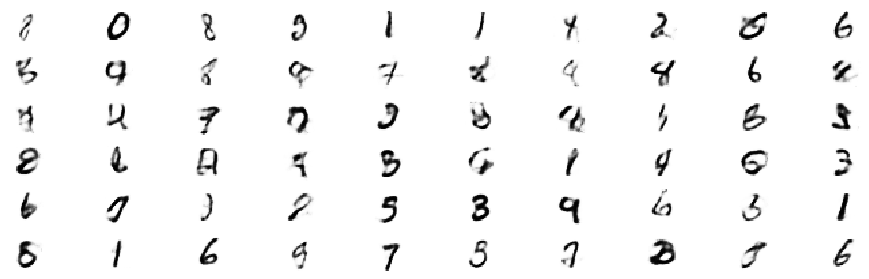

In [60]:
plt.figure(figsize=(16, 50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

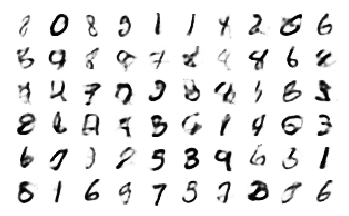

In [69]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
plt.show()

In [70]:
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

In [71]:
n_digits = 3 
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess,"./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_batch})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


In [72]:
with tf.Session() as sess:
    saver.restore(sess,"./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X:X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


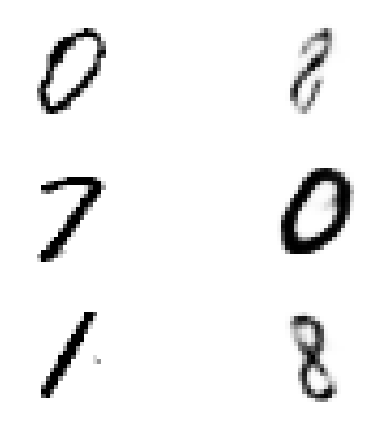

In [75]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


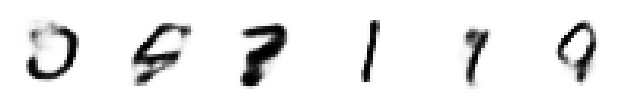

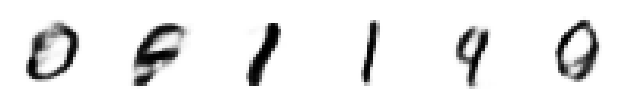

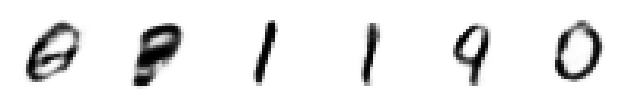

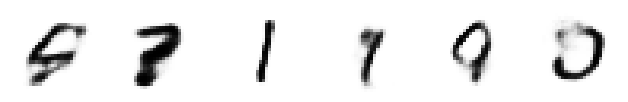

In [76]:
n_iterations = 3 
n_digits = 6 
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis = 0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1,n_digits, digit_index +1)
            plot_image(outputs_val[digit_index])
        plt.show()